# AES 프로파일링 공격

In [1]:
from keras import models
from keras import layers
from keras.layers import Dense
from keras.layers import Dropout, Flatten
from keras import optimizers
from keras.layers import BatchNormalization

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from IPython.display import Image

from tqdm import tqdm
import datetime
import time
import struct

from typing import Tuple, Optional
import keras.utils

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# 내 드라이브(mydrive)에 연결
# from google.colab import drive
# drive.mount('/content/drive')

[]


In [3]:
def Pretreatment():
    print(os.getcwd())
    file_path1 = "/Users/choealog/Desktop/crypto/2023-겨울/부채널/2.머신러닝/AESSideChannelAttack/Train_profile_device/"
    file_path2 = "/Users/choealog/Desktop/crypto/2023-겨울/부채널/2.머신러닝/AESSideChannelAttack/Test_target_device/"

    print()
    os.chdir(file_path1)
    file_in_path1 = os.listdir()
    for i in file_in_path1:
        print(i)   
    print("학습할 파일 목록은 위와 같습니다.")  
    print()

    os.chdir(file_path2)
    file_in_path2 = os.listdir()
    for i in file_in_path2:
        print(i)   
    print("공격할 파일 목록은 위와 같습니다.") 
    print()
    
    flag = 0
    for idx in file_in_path1:
        if "trace" in idx:
            profile_trace  = np.load(file_path1 + idx)
            flag += 1
        if "textin" in idx:
            profile_textin = np.load(file_path1 + idx)
            flag += 1
        if "keylist" in idx:
            profile_keylist = np.load(file_path1 + idx)
            flag += 1
    if flag != 3:
        print("학습 폴더 내에 파일 없음.")
        return 0
        
    flag = 0
    for idx in file_in_path2:
        if "trace" in idx:
            attack_trace  = np.load(file_path2 + idx)
            flag += 1
        if "textin" in idx:
            attack_textin = np.load(file_path2 + idx)
            flag += 1
        if "keylist" in idx:
            attack_keylist = np.load(file_path2 + idx)
            flag += 1
    if flag != 3:
        print("공격 폴더 내에 파일 없음.")
        return 0
        
    print()
    print("학습 폴더 내의 파형 개수           : ", len(profile_trace))
    print("학습 폴더 내의 전체 평문 개수      : ", len(profile_textin))
    print("학습 폴더 내의 전체 키 리스트 개수 : ", len(profile_keylist))

    print()
    print("공격 폴더 내의 파형 개수           : ", len(attack_trace))
    print("공격 폴더 내의 전체 평문 길이      : ", len(attack_textin))
    print("고정된 키 값: ", attack_keylist[0])

    return profile_trace, profile_textin, profile_keylist, attack_trace, attack_textin, attack_keylist

# 구글 드라이브 연결

#프로파일링 AES

- 키가 고정되어 있지 않음
- 우리가 파형을 수집하는 디바이스임
    - train_Pretreatment(): 학습시킬 데이터(평문, 파형, 키 리스트) 불러오는 코드
    - attack_Pretreatment(): 공격할 데이터(평문, 파형, 키 리스트) 불러오는 코드

In [4]:
# /content/drive/MyDrive/230223_STM32F 파형 실습/Test_target_device/Train_profile device
# /content/drive/MyDrive/230223_STM32F 파형 실습/Test_target_device/Test_target device
profile_trace, profile_textin, profile_keylist, attack_trace, attack_textin, attack_keylist = Pretreatment()

/Users/choealog/Desktop/crypto/2023-겨울/부채널/2.머신러닝/AESSideChannelAttack

.DS_Store
2023.02.14-16.09.29_textin.npy
config_2023.02.14-16.09.29_.cfg
2023.02.14-16.09.29_settings.cwset
2023.02.14-16.09.29_keylist.npy.py
2023.02.14-16.09.29_textout.npy
traces.npy
2023.02.14-16.09.29_knownkey.npy
학습할 파일 목록은 위와 같습니다.

2023.02.14-15.57.24_settings.cwset
2023.02.14-15.57.24_traces.npy
2023.02.14-15.57.24_keylist.npy
2023.02.14-15.57.24_textout.npy
MLSCA
2023.02.14-15.57.24_knownkey.npy
config_2023.02.14-15.57.24_.cfg
2023.02.14-15.57.24_textin.npy
공격할 파일 목록은 위와 같습니다.


학습 폴더 내의 파형 개수           :  10000
학습 폴더 내의 전체 평문 개수      :  10000
학습 폴더 내의 전체 키 리스트 개수 :  10000

공격 폴더 내의 파형 개수           :  1000
공격 폴더 내의 전체 평문 길이      :  1000
고정된 키 값:  [ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]


## 파형 정규화

In [5]:
#**#(파형자르기), (정규화하기)
# 학습 데이터
profile_trace_normal = np.array(profile_trace[:])[:,2000:3000] 

for i in range(profile_trace.shape[0]):
    profile_trace_normal[i] -= profile_trace_normal[i].mean()
    MIN = min(profile_trace_normal[i])
    MAX = max(profile_trace_normal[i])
    profile_trace_normal[i] = ((profile_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2 

In [6]:
# attack data
# 공격 데이터
attack_trace_normal = np.array(attack_trace[:])[:,2000:3000] 

for i in range(attack_trace.shape[0]):
    attack_trace_normal[i] -= attack_trace_normal[i].mean()
    MIN = min(attack_trace_normal[i])
    MAX = max(attack_trace_normal[i])
    attack_trace_normal[i] = ((attack_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2 

print(len(profile_trace_normal[0]))
print(len(attack_trace_normal[0])) 

1000
1000


## 파형 개형 확인 (SPA)

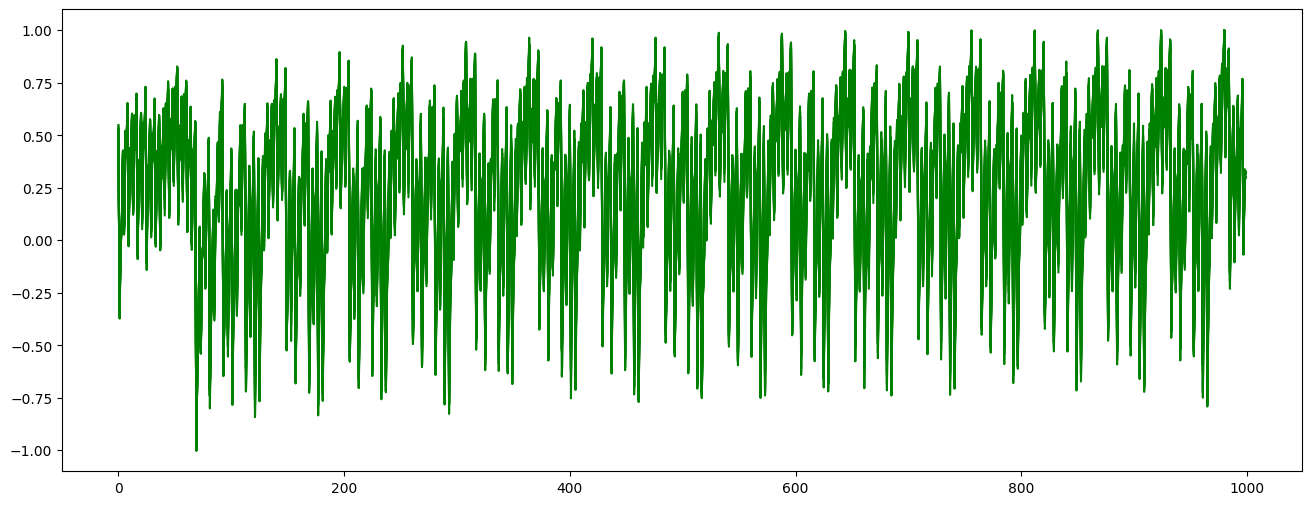

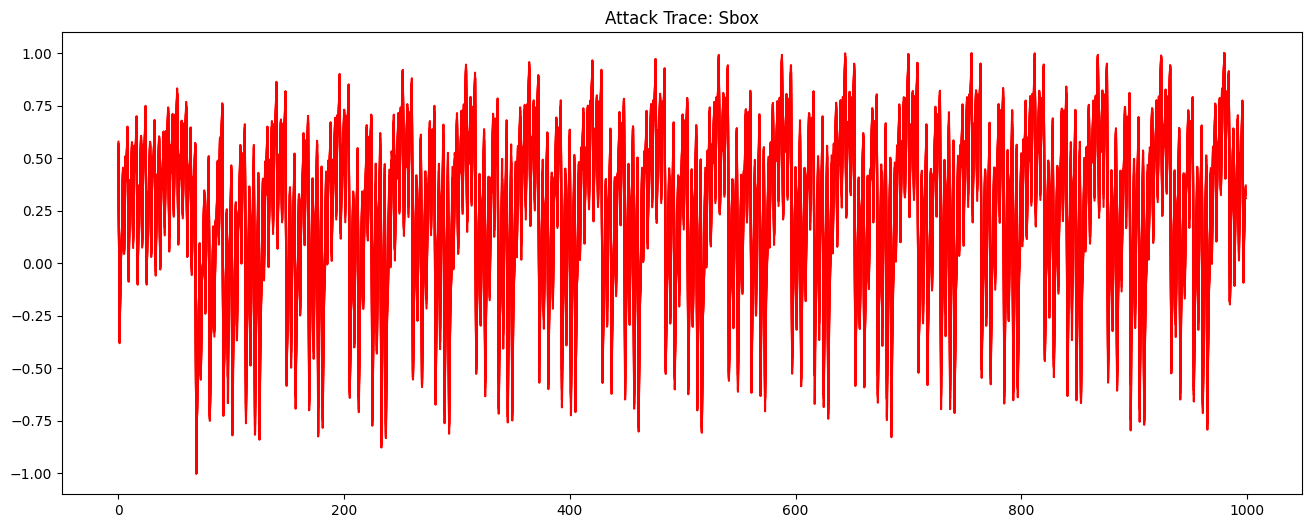

In [7]:
# profiling data 개형 확인
plt.figure(figsize = (16,6))
x_range1 = range(0, len(profile_trace_normal[0]))
for i in range(10):
    plt.plot(x_range1, profile_trace_normal[i], color = 'green')
    plt.title("")
plt.show()
print()
# attack data 개형 확인
plt.figure(figsize = (16,6))
x_range2 = range(0, len(attack_trace_normal[1]))
for i in range(10): 
    plt.plot(x_range2, attack_trace_normal[i], color = 'red')
    plt.title("Attack Trace: Sbox")
plt.show()

In [8]:
# SBox 테이블 선언
SBox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

## 데이터 0번째 바이트 추출하기
- 공격 대상 바이트에 따라서 달라짐

In [9]:
b = []
c = []
d = []
target_index = 0

l = profile_textin[0] # 길이 10000개
for i in range(len(profile_textin)):
    k = profile_textin[i][target_index]
    b.append(k)
pp = np.array(b).reshape(10000, 1)


l = profile_keylist[0] # 길이 10000개
for i in range(len(profile_keylist)):
    k = profile_keylist[i][target_index]
    c.append(k)

pk = np.array(c).reshape(10000, 1)

l = attack_keylist[0] # 길이 16
k = attack_keylist[0][target_index]
d.append(k)

ak = np.array(d).reshape(1, 1)

print(pp.shape)
print(pk.shape)
print(ak.shape)

(10000, 1)
(10000, 1)
(1, 1)


In [10]:
num_traces = profile_trace.shape[0]
num_training = int(num_traces * 0.7)

profile_SBox = SBox[pp ^ pk]

'''
현재 10000개의 파형에 대해서 
9000개: 학습 데이터
1000개: 검증 데이터
로 사용중임
'''
# 데이터 셔플링 해주기
# 이건 옵션임
rand_index = np.arange(0, num_traces)
np.random.shuffle(rand_index)

# 학습: 입력(x_train)과 레이블(y_train)을 설정
x_train = profile_trace_normal[rand_index[:num_training]]
y_train = profile_SBox[rand_index[:num_training]]

# 검증: 입력(x_valid)과 레이블(y_valid)을 설정
x_valid = profile_trace_normal[rand_index[num_training:]]
y_valid = profile_SBox[rand_index[num_training:]]

# 학습 데이터와 검증 데이터의 shape
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(7000, 1000)
(7000, 1)
(3000, 1000)
(3000, 1)


In [11]:
# 원핫 인코딩
# 물론 이 부분도 옵션임


category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot = category(y_train[:])
y_valid_onehot = category(y_valid[:])

# 원핫 인코딩 결과
print(y_train_onehot.shape)
print(y_valid_onehot.shape)

(7000, 256)
(3000, 256)


In [12]:
# 신경망 구성 함수
# Points_len : 입력 포인트 길이
# Hidden_node: 은닉층 (층 수랑 해당 층의 노드 수도 결정 가능)
# Output_node: 출력층
# Activations: 활성화 함수
# Dropout    : 드롭 아웃 유무
# BatchNo    : 배치 정규화
# 파라미터 설정 안 할 시 def build_MLP() 안에 정의한 디폴트 값으로 들어가게 됨.

def build_MLP(Points_len = 1000, Hidden_node = [400, 300], Output_node = 256, Activations = "relu", Dropout = False, BatchNo = False):

    # 입력층
    inp = keras.layers.Input(shape = (Points_len, ), name = "input") 

    # 입력층 배치 정규화
    # 옵션
    Hidden_layer = keras.layers.BatchNormalization()(inp)

    for node in Hidden_node:
        # 은닉층 추가
        Hidden_layer = keras.layers.Dense(node, activation = Activations)(Hidden_layer)
        if Dropout: # 드롭아웃 수행, 퍼센트 조절 가능
            Hidden_layer = keras.layers.Dropout(0.5)(Hidden_layer)
        if BatchNo: # 배치 정규화 수행, 배치 정규화 할지 말지 결정 
            Hidden_layer = keras.layers.BatchNormalization()(Hidden_layer)
    
    # 활성화 함수를 softmax로 설정 (각 class일 확률을 반환)
    out = keras.layers.Dense(Output_node, activation = 'softmax', name = 'output')(Hidden_layer)

    # 입력층과 출력층을 받아서 객체화
    m = keras.Model(inp, out)

    # 손실함수를 categorical_crossentropy
    # 성능 지표를 '정확도'로 설정하여 모델을 구성
    m.compile(optimizer = keras.optimizers.legacy.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    # 모델 shape과 파라미터 수를 출력
    m.summary()

    return m

In [13]:
SCA_MLP = build_MLP(1000, [500, 400, 300], 256, "relu", True, True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000)]            0         
                                                                 
 batch_normalization (Batch  (None, 1000)              4000      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 500)               500500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 500)               2000      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 400)               200400

In [14]:
# 신경망 학습
# 파라미터 넣어서 쓰면 됨.
def train(model, Init, epochs, x_train, y_train, x_valid, y_valid, batch_size, verbose, file_name):

    # 조기 종료
    # epoch 20 동안 validation accuracy의 향상이 없으면 학습 중지
    earlystop = keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 20, verbose = 1)
    # validation accuracy가 향상된 결과의 모델 파라미터만 저장
    checkpoint = keras.callbacks.ModelCheckpoint(filepath = './MLSCA', monitor = 'val_accuracy', verbose = verbose, save_best_only = True, mode = 'max')
    # 학습 시작 시간 측정
    print("Training started: ", datetime.datetime.now())
    start = time.time()
    
    # 가중치 초기화 
    # 비교하려면 처음 값을 저장해놓고 사용하면 됨.
    model.set_weights(Init)

    # 신경망 학습 수행
    model.fit(x = x_train, y = y_train, validation_data = (x_valid, y_valid), initial_epoch = 0, epochs = epochs, batch_size = batch_size, callbacks=[checkpoint], verbose = verbose)

    # 학습 종료 시간 측정 및 소요 시간 계산
    elapsed = time.time() - start
    print("Training ended: ", datetime.datetime.now())
    print("Elapsed", elapsed)
    
    val_loss_load = model.history.history['val_loss']
    val_acc_load = model.history.history['val_accuracy']
    loss_load = model.history.history['loss']
    acc_load = model.history.history['accuracy']

    # 학습 결과 그래프 출력
    fig = plt.figure(figsize = (16, 6))
    ax = plt.subplot(1, 2, 1)
    ax.plot(loss_load)
    ax.plot(val_loss_load)
    ax.legend(['loss','val_loss'])
    ax = plt.subplot(1, 2, 2)
    ax.plot(acc_load)
    ax.plot(val_acc_load)
    ax.legend(['accuracy','val_accuracy'])
    plt.savefig(file_name + 'val_loss_and_acc.png')
    plt.show()
    
    # 학습 결과, 손실값과 정확도를 파일로 저장
    np.savetxt(file_name+"val_loss.txt", val_loss_load)
    np.savetxt(file_name+"val_acc.txt", val_acc_load)

Training started:  2024-04-02 16:03:24.863651
Epoch 1/40
228/234 [============================>.] - ETA: 0s - loss: 5.9610 - accuracy: 0.0041
Epoch 1: val_accuracy improved from -inf to 0.00633, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 5.9574 - accuracy: 0.0041 - val_loss: 5.5505 - val_accuracy: 0.0063
Epoch 2/40
232/234 [============================>.] - ETA: 0s - loss: 5.5453 - accuracy: 0.0126
Epoch 2: val_accuracy improved from 0.00633 to 0.02533, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 5.5442 - accuracy: 0.0126 - val_loss: 5.0972 - val_accuracy: 0.0253
Epoch 3/40
233/234 [============================>.] - ETA: 0s - loss: 5.0859 - accuracy: 0.0223
Epoch 3: val_accuracy improved from 0.02533 to 0.04733, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 5.0860 - accuracy: 0.0223 - val_loss: 4.5164 - val_accuracy: 0.0473
Epoch 4/40
223/234 [===========================>..] - ETA: 0s - loss: 4.6425 - accuracy: 0.0398
Epoch 4: val_accuracy improved from 0.04733 to 0.09133, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 4.6271 - accuracy: 0.0404 - val_loss: 3.8172 - val_accuracy: 0.0913
Epoch 5/40
233/234 [============================>.] - ETA: 0s - loss: 4.0781 - accuracy: 0.0695
Epoch 5: val_accuracy improved from 0.09133 to 0.17900, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 4.0773 - accuracy: 0.0696 - val_loss: 3.2123 - val_accuracy: 0.1790
Epoch 6/40
234/234 [==============================] - ETA: 0s - loss: 3.6991 - accuracy: 0.0909
Epoch 6: val_accuracy improved from 0.17900 to 0.23767, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 3.6991 - accuracy: 0.0909 - val_loss: 2.8194 - val_accuracy: 0.2377
Epoch 7/40
222/234 [===========================>..] - ETA: 0s - loss: 3.4212 - accuracy: 0.1191
Epoch 7: val_accuracy improved from 0.23767 to 0.31800, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 3.4191 - accuracy: 0.1184 - val_loss: 2.5495 - val_accuracy: 0.3180
Epoch 8/40
229/234 [============================>.] - ETA: 0s - loss: 3.2222 - accuracy: 0.1316
Epoch 8: val_accuracy improved from 0.31800 to 0.36633, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 3.2198 - accuracy: 0.1320 - val_loss: 2.3530 - val_accuracy: 0.3663
Epoch 9/40
233/234 [============================>.] - ETA: 0s - loss: 3.0597 - accuracy: 0.1536
Epoch 9: val_accuracy improved from 0.36633 to 0.39567, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 3.0600 - accuracy: 0.1539 - val_loss: 2.1762 - val_accuracy: 0.3957
Epoch 10/40
222/234 [===========================>..] - ETA: 0s - loss: 2.9459 - accuracy: 0.1695
Epoch 10: val_accuracy improved from 0.39567 to 0.45567, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.9480 - accuracy: 0.1693 - val_loss: 2.0302 - val_accuracy: 0.4557
Epoch 11/40
234/234 [==============================] - ETA: 0s - loss: 2.8489 - accuracy: 0.1857
Epoch 11: val_accuracy did not improve from 0.45567
234/234 [==============================] - 1s 4ms/step - loss: 2.8489 - accuracy: 0.1857 - val_loss: 1.9512 - val_accuracy: 0.4417
Epoch 12/40
223/234 [===========================>..] - ETA: 0s - loss: 2.7801 - accuracy: 0.1933
Epoch 12: val_accuracy improved from 0.45567 to 0.48400, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.7773 - accuracy: 0.1934 - val_loss: 1.8527 - val_accuracy: 0.4840
Epoch 13/40
234/234 [==============================] - ETA: 0s - loss: 2.7191 - accuracy: 0.2019
Epoch 13: val_accuracy improved from 0.48400 to 0.53100, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.7191 - accuracy: 0.2019 - val_loss: 1.7643 - val_accuracy: 0.5310
Epoch 14/40
234/234 [==============================] - ETA: 0s - loss: 2.6650 - accuracy: 0.2157
Epoch 14: val_accuracy improved from 0.53100 to 0.55000, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.6650 - accuracy: 0.2157 - val_loss: 1.6890 - val_accuracy: 0.5500
Epoch 15/40
222/234 [===========================>..] - ETA: 0s - loss: 2.6107 - accuracy: 0.2228
Epoch 15: val_accuracy did not improve from 0.55000
234/234 [==============================] - 1s 4ms/step - loss: 2.6020 - accuracy: 0.2234 - val_loss: 1.6381 - val_accuracy: 0.5357
Epoch 16/40
222/234 [===========================>..] - ETA: 0s - loss: 2.5331 - accuracy: 0.2368
Epoch 16: val_accuracy improved from 0.55000 to 0.60967, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.5325 - accuracy: 0.2371 - val_loss: 1.5531 - val_accuracy: 0.6097
Epoch 17/40
222/234 [===========================>..] - ETA: 0s - loss: 2.4636 - accuracy: 0.2589
Epoch 17: val_accuracy did not improve from 0.60967
234/234 [==============================] - 1s 4ms/step - loss: 2.4602 - accuracy: 0.2597 - val_loss: 1.4813 - val_accuracy: 0.6077
Epoch 18/40
222/234 [===========================>..] - ETA: 0s - loss: 2.3142 - accuracy: 0.2892
Epoch 18: val_accuracy improved from 0.60967 to 0.67667, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.3202 - accuracy: 0.2899 - val_loss: 1.3187 - val_accuracy: 0.6767
Epoch 19/40
222/234 [===========================>..] - ETA: 0s - loss: 2.3138 - accuracy: 0.3014
Epoch 19: val_accuracy improved from 0.67667 to 0.73567, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.3058 - accuracy: 0.3023 - val_loss: 1.2001 - val_accuracy: 0.7357
Epoch 20/40
234/234 [==============================] - ETA: 0s - loss: 2.1707 - accuracy: 0.3371
Epoch 20: val_accuracy improved from 0.73567 to 0.74467, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.1707 - accuracy: 0.3371 - val_loss: 1.1223 - val_accuracy: 0.7447
Epoch 21/40
234/234 [==============================] - ETA: 0s - loss: 2.0924 - accuracy: 0.3516
Epoch 21: val_accuracy improved from 0.74467 to 0.78400, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 2.0924 - accuracy: 0.3516 - val_loss: 1.0295 - val_accuracy: 0.7840
Epoch 22/40
234/234 [==============================] - ETA: 0s - loss: 1.9472 - accuracy: 0.3956
Epoch 22: val_accuracy improved from 0.78400 to 0.81167, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.9472 - accuracy: 0.3956 - val_loss: 0.9018 - val_accuracy: 0.8117
Epoch 23/40
232/234 [============================>.] - ETA: 0s - loss: 1.9309 - accuracy: 0.3938
Epoch 23: val_accuracy improved from 0.81167 to 0.84833, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.9335 - accuracy: 0.3937 - val_loss: 0.7956 - val_accuracy: 0.8483
Epoch 24/40
233/234 [============================>.] - ETA: 0s - loss: 1.8598 - accuracy: 0.4200
Epoch 24: val_accuracy improved from 0.84833 to 0.85500, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.8612 - accuracy: 0.4197 - val_loss: 0.7189 - val_accuracy: 0.8550
Epoch 25/40
234/234 [==============================] - ETA: 0s - loss: 1.7626 - accuracy: 0.4494
Epoch 25: val_accuracy improved from 0.85500 to 0.88933, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.7626 - accuracy: 0.4494 - val_loss: 0.6357 - val_accuracy: 0.8893
Epoch 26/40
222/234 [===========================>..] - ETA: 0s - loss: 1.6419 - accuracy: 0.4722
Epoch 26: val_accuracy did not improve from 0.88933
234/234 [==============================] - 1s 5ms/step - loss: 1.6453 - accuracy: 0.4704 - val_loss: 0.6054 - val_accuracy: 0.8820
Epoch 27/40
232/234 [============================>.] - ETA: 0s - loss: 1.5889 - accuracy: 0.4981
Epoch 27: val_accuracy improved from 0.88933 to 0.91333, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.5923 - accuracy: 0.4973 - val_loss: 0.5396 - val_accuracy: 0.9133
Epoch 28/40
222/234 [===========================>..] - ETA: 0s - loss: 1.5412 - accuracy: 0.5137
Epoch 28: val_accuracy did not improve from 0.91333
234/234 [==============================] - 1s 4ms/step - loss: 1.5393 - accuracy: 0.5130 - val_loss: 0.5231 - val_accuracy: 0.8933
Epoch 29/40
222/234 [===========================>..] - ETA: 0s - loss: 1.5349 - accuracy: 0.5126
Epoch 29: val_accuracy improved from 0.91333 to 0.91567, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.5290 - accuracy: 0.5144 - val_loss: 0.4739 - val_accuracy: 0.9157
Epoch 30/40
234/234 [==============================] - ETA: 0s - loss: 1.4449 - accuracy: 0.5300
Epoch 30: val_accuracy improved from 0.91567 to 0.92533, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.4449 - accuracy: 0.5300 - val_loss: 0.4450 - val_accuracy: 0.9253
Epoch 31/40
227/234 [============================>.] - ETA: 0s - loss: 1.4030 - accuracy: 0.5413
Epoch 31: val_accuracy did not improve from 0.92533
234/234 [==============================] - 1s 5ms/step - loss: 1.4016 - accuracy: 0.5414 - val_loss: 0.4148 - val_accuracy: 0.9247
Epoch 32/40
234/234 [==============================] - ETA: 0s - loss: 1.3965 - accuracy: 0.5507
Epoch 32: val_accuracy improved from 0.92533 to 0.92900, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.3965 - accuracy: 0.5507 - val_loss: 0.4045 - val_accuracy: 0.9290
Epoch 33/40
222/234 [===========================>..] - ETA: 0s - loss: 1.3435 - accuracy: 0.5680
Epoch 33: val_accuracy improved from 0.92900 to 0.93167, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.3413 - accuracy: 0.5696 - val_loss: 0.3791 - val_accuracy: 0.9317
Epoch 34/40
222/234 [===========================>..] - ETA: 0s - loss: 1.3776 - accuracy: 0.5652
Epoch 34: val_accuracy improved from 0.93167 to 0.93767, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.3764 - accuracy: 0.5651 - val_loss: 0.3620 - val_accuracy: 0.9377
Epoch 35/40
234/234 [==============================] - ETA: 0s - loss: 1.2395 - accuracy: 0.5957
Epoch 35: val_accuracy improved from 0.93767 to 0.94900, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.2395 - accuracy: 0.5957 - val_loss: 0.3208 - val_accuracy: 0.9490
Epoch 36/40
222/234 [===========================>..] - ETA: 0s - loss: 1.2440 - accuracy: 0.6024
Epoch 36: val_accuracy did not improve from 0.94900
234/234 [==============================] - 1s 4ms/step - loss: 1.2440 - accuracy: 0.6017 - val_loss: 0.3242 - val_accuracy: 0.9430
Epoch 37/40
222/234 [===========================>..] - ETA: 0s - loss: 1.2107 - accuracy: 0.6128
Epoch 37: val_accuracy did not improve from 0.94900
234/234 [==============================] - 1s 4ms/step - loss: 1.2088 - accuracy: 0.6150 - val_loss: 0.3233 - val_accuracy: 0.9320
Epoch 38/40
222/234 [===========================>..] - ETA: 0s - loss: 1.1614 - accuracy: 0.6191
Epoch 38: val_accuracy improved from 0.94900 to 0.94933, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets


INFO:tensorflow:Assets written to: ./MLSCA/assets


234/234 [==============================] - 2s 7ms/step - loss: 1.1621 - accuracy: 0.6183 - val_loss: 0.2784 - val_accuracy: 0.9493
Epoch 39/40
230/234 [============================>.] - ETA: 0s - loss: 1.1993 - accuracy: 0.6130
Epoch 39: val_accuracy did not improve from 0.94933
234/234 [==============================] - 1s 5ms/step - loss: 1.1975 - accuracy: 0.6136 - val_loss: 0.2919 - val_accuracy: 0.9473
Epoch 40/40
234/234 [==============================] - ETA: 0s - loss: 1.1462 - accuracy: 0.6241
Epoch 40: val_accuracy did not improve from 0.94933
234/234 [==============================] - 1s 5ms/step - loss: 1.1462 - accuracy: 0.6241 - val_loss: 0.2748 - val_accuracy: 0.9477
Training ended:  2024-04-02 16:04:23.483084
Elapsed 58.61934208869934


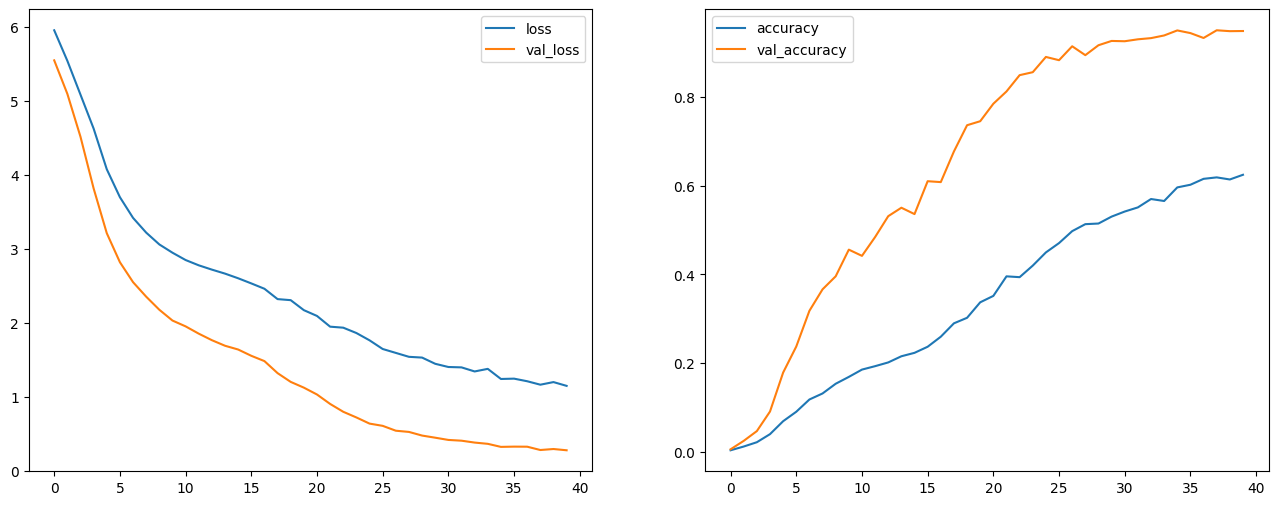

In [15]:
# 초기화에 사용할 가중치 배열 설정
# 다른 활성화 함수와 비교시 이 값을 저장해두고 사용하면 됨.
init_weights = SCA_MLP.get_weights()

# 학습 수행
# 마지막에는 결과가 저장되는 폴더명을 입력해주는 것                                                               
train(SCA_MLP, init_weights, 40, x_train, y_train_onehot, x_valid, y_valid_onehot, 30, 1, '/Users/choealog/Desktop/crypto/2023-겨울/부채널/2.머신러닝/AESSideChannelAttack')

In [16]:
invsbox = np.array([
    0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
    0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
    0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
    0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
    0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
    0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
    0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
    0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
    0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
    0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
    0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
    0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
    0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
    0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
    0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d
])

In [17]:
# 학습된 신경망 사용하여 키 추출하는 함수
def predict_MLP(model, trace_test, pts_test):

    # 신경망의 출력 값(sbox 출력 값) 획득
    predict_sbox = model.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
    sbox_out_val = np.argmax(predict_sbox, axis = 1)

    # inverse sbox 적용하여 sbox 입력 값 계산
    sbox_in_val = invsbox[sbox_out_val.astype(int)]

    # 평문을 XOR하여 추측 키 값 계산
    guess_keys = sbox_in_val ^ pts_test

    # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_keys, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key = np.argmax(key_count)

    # 키 후보 별 카운트 그래프 출력
    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()

    # 예상 후보 키를 출력
    print('right key: ', hex(pred_key))
    print('key counts: ',int(key_count[np.argmax(key_count)]))

    return pred_key

32/32 [==============================] - 0s 1ms/step


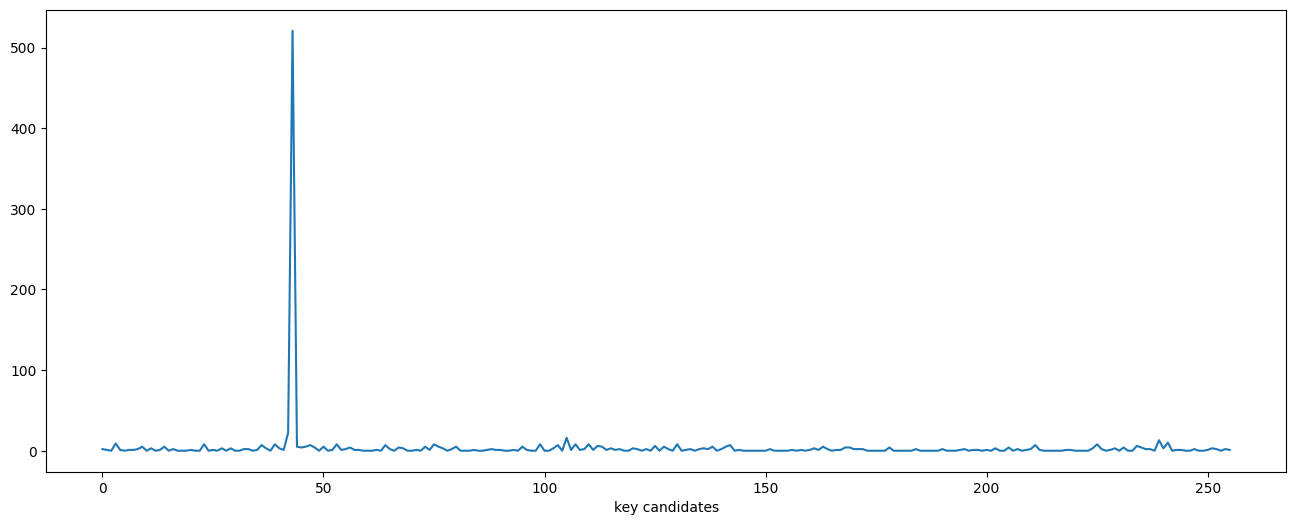

right key:  0x2b
key counts:  521


In [18]:
pred_key = predict_MLP(SCA_MLP, attack_trace_normal, attack_textin[:,target_index])